In [ ]:
# Monter Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Naviguer vers le dossier contenant le dataset
import os
dataset_path = '/content/drive/My Drive/VehiclesDetectionDataset'
os.listdir(dataset_path)

Préparer l’environnement

In [1]:
# Vérifier le GPU
import torch
print("Torch:", torch.__version__)
print("CUDA dispo:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU:", torch.cuda.get_device_name(0))

# Installer YOLOv8
!pip -q install ultralytics opencv-python matplotlib

from ultralytics import YOLO
YOLO

Torch: 2.8.0+cu126
CUDA dispo: True
GPU: Tesla T4
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 32.1 MB/s eta 0:00:00
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


ultralytics.models.yolo.model.YOLO

Entraînement (Python)

In [2]:
from ultralytics import YOLO

model = YOLO("yolov8n.pt")

results = model.train(
    data="coco128.yaml",
    epochs=20,
    imgsz=640,
    batch=16,
    device=0 if torch.cuda.is_available() else 'cpu',
    patience=10,
    workers=2
)

print(results)

Ultralytics 8.3.227 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=coco128.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=20, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=10, perspective=0.0, plots=True, pose=12.0, pretrained=True

 Évaluation + visualisation

Dernier run: runs/detect/train


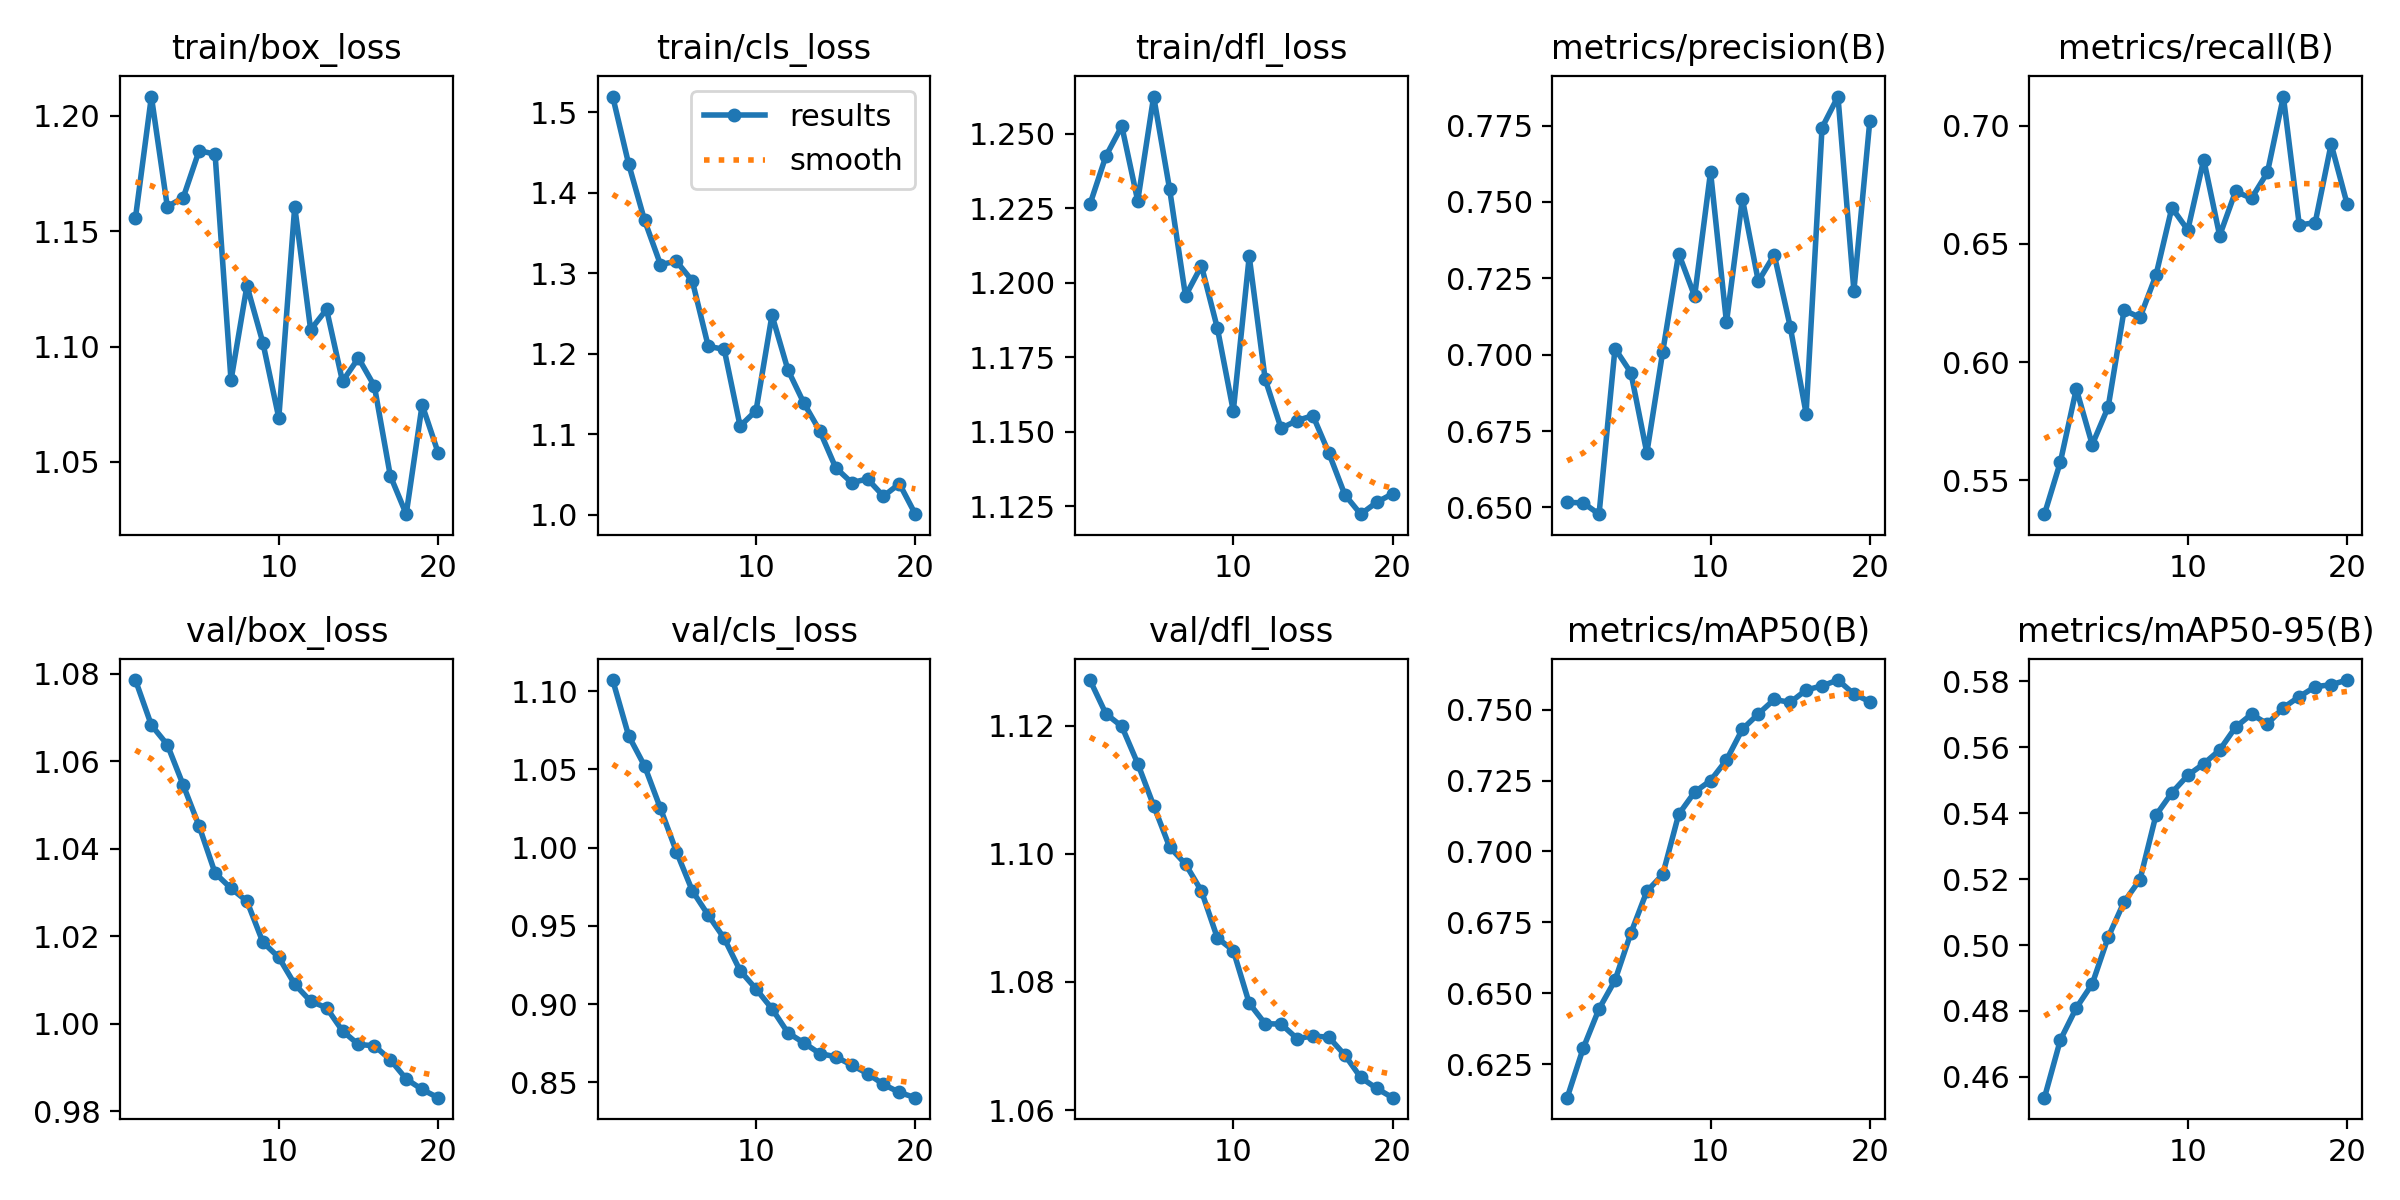

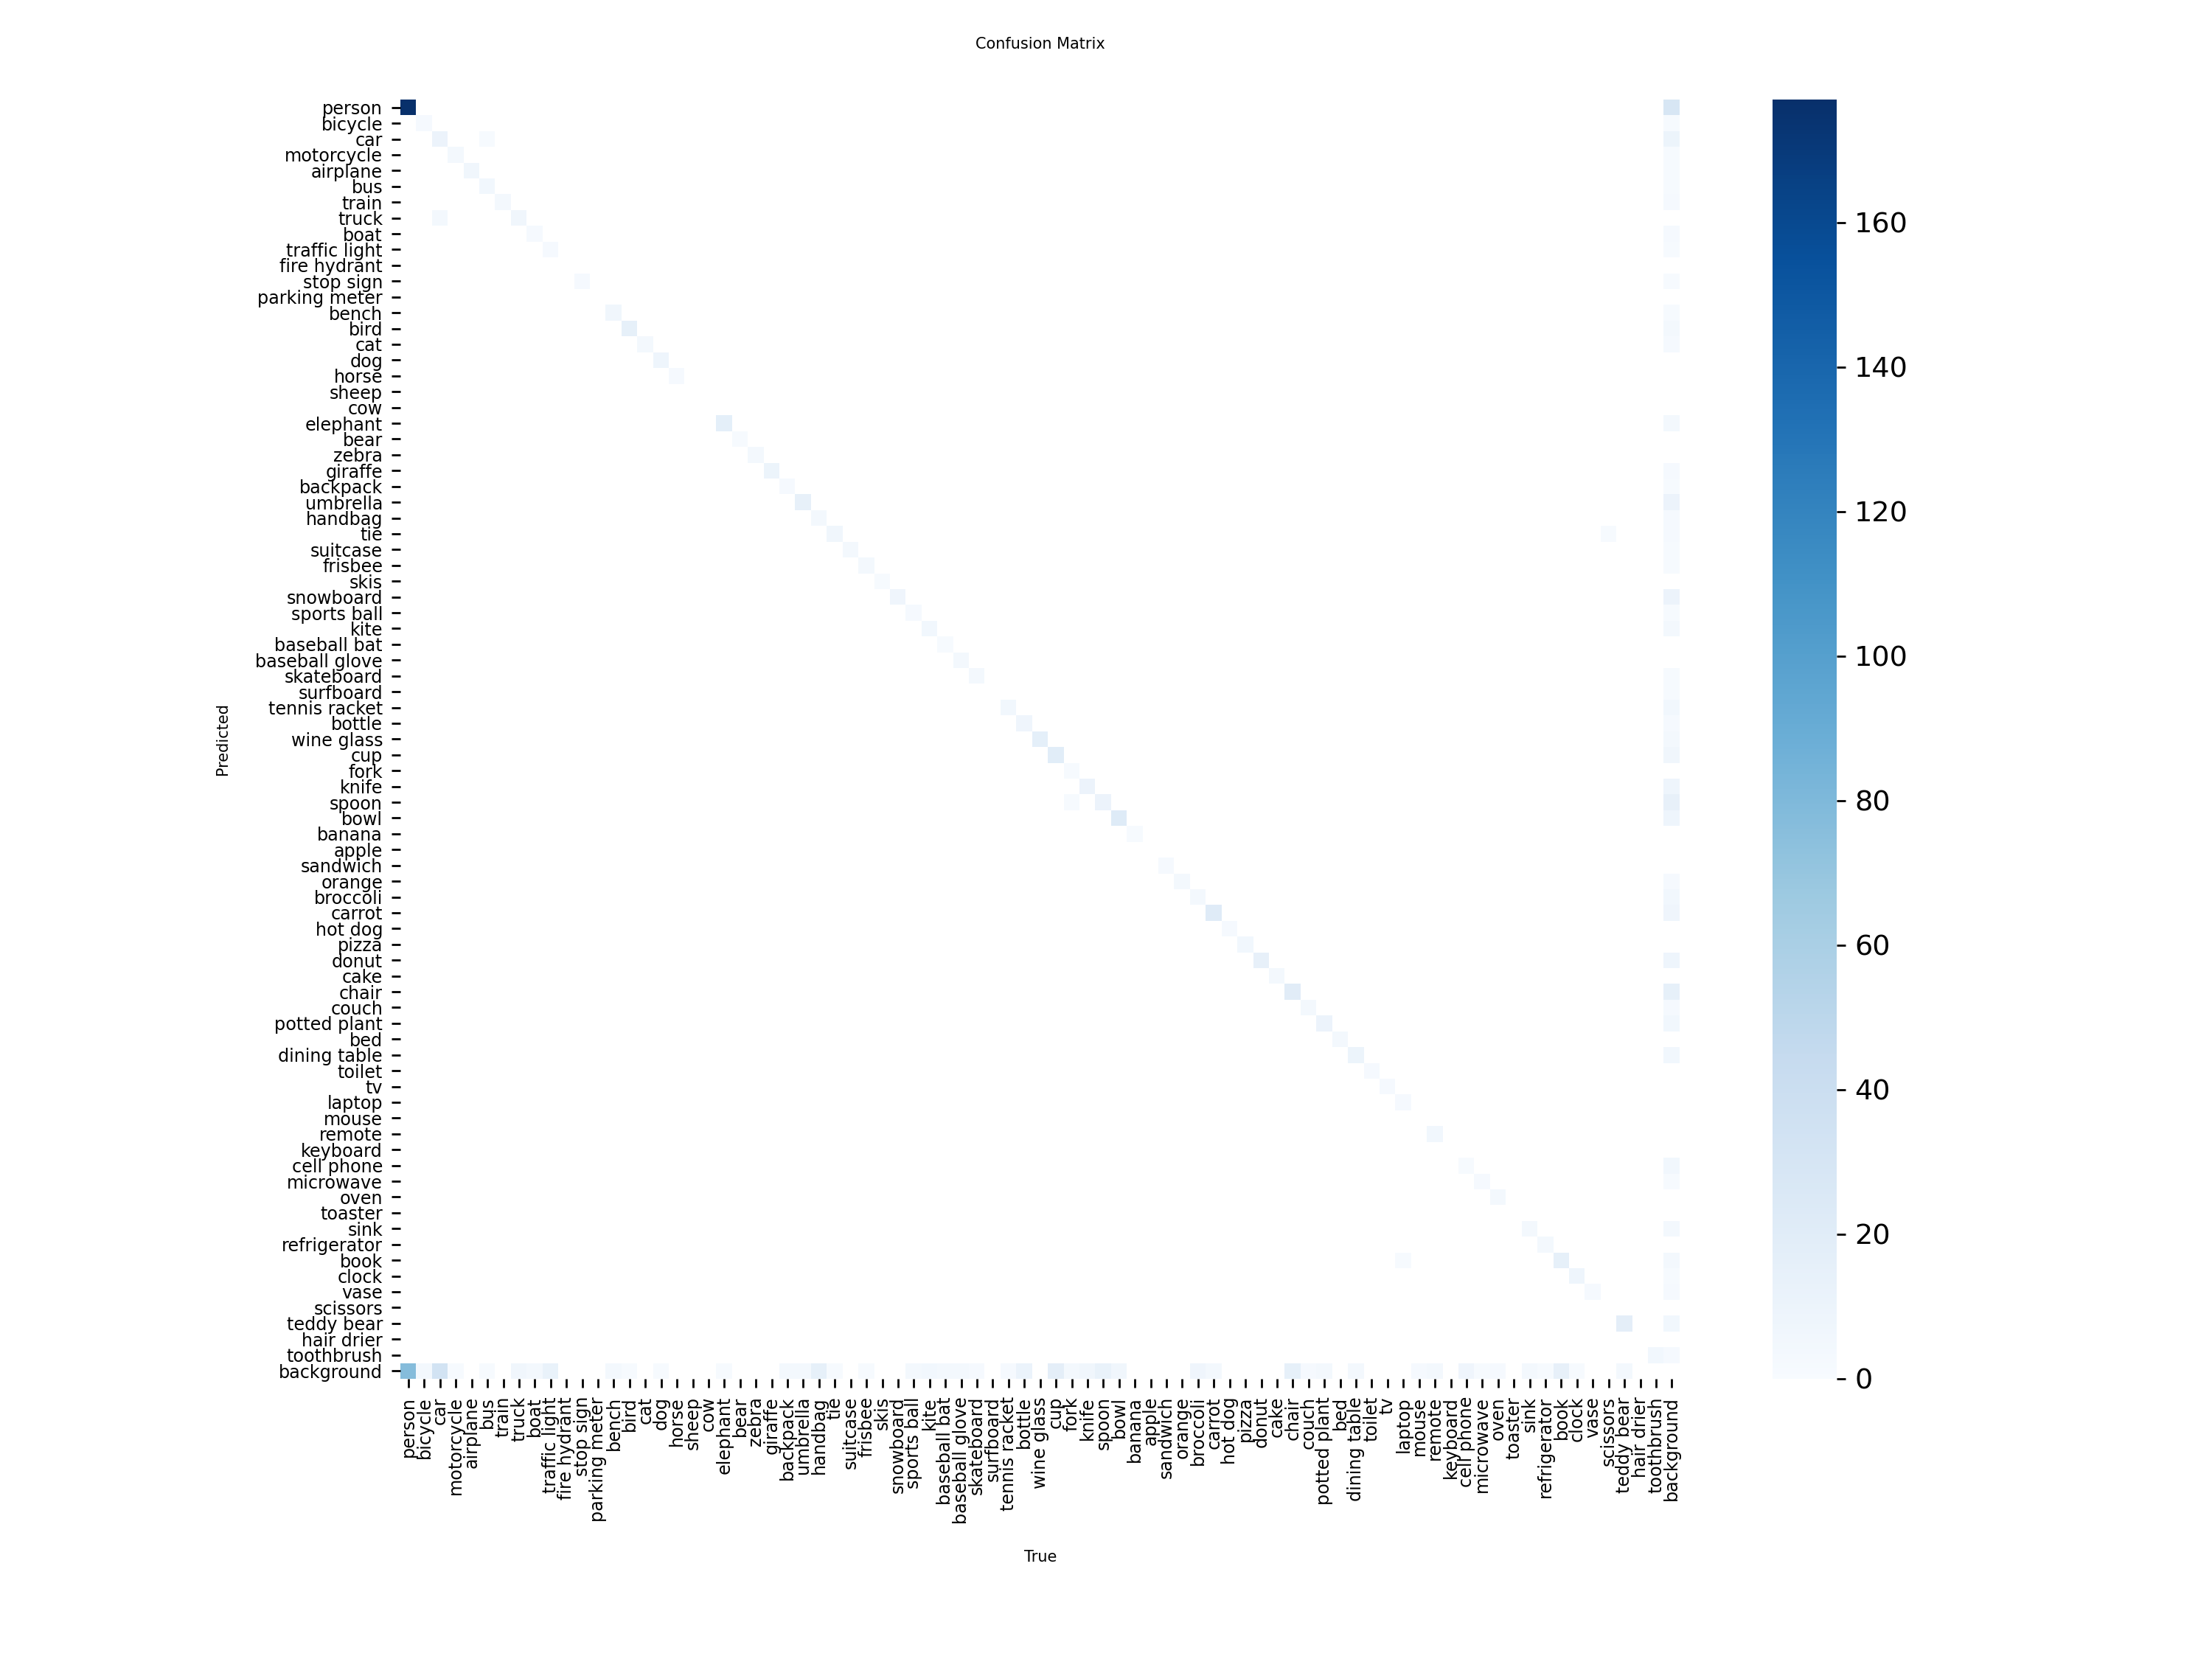

In [3]:
import IPython, os, glob

runs = sorted(glob.glob("runs/detect/train*"))
run_dir = runs[-1]
print("Dernier run:", run_dir)

for img_name in ["results.png", "confusion_matrix.png", "PR_curve.png", "F1_curve.png"]:
    path = os.path.join(run_dir, img_name)
    if os.path.exists(path):
        display(IPython.display.Image(filename=path, width=800))

 Validation (mAP)

In [4]:
!yolo detect val model={run_dir}/weights/best.pt data=coco128.yaml imgsz=640

Ultralytics 8.3.227 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1332.0±183.8 MB/s, size: 50.1 KB)
val: Scanning /content/datasets/coco128/labels/train2017.cache... 126 images, 2 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 128/128 1.5Mit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 8/8 1.3it/s 6.2s
                   all        128        929      0.785      0.678      0.752      0.584
                person         61        254       0.91      0.636      0.793      0.585
               bicycle          3          6      0.777      0.333      0.469      0.392
                   car         12         46      0.784      0.236      0.377      0.224
            motorcycle          4          5      0.817        0.8      0.962      0.833
              airplane          5      

Inférence sur images

Ultralytics 8.3.227 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs

image 1/1 /content/test_images/bus.jpg: 640x480 3 persons, 1 bus, 1 stop sign, 1 skateboard, 49.2ms
Speed: 5.8ms preprocess, 49.2ms inference, 4.1ms postprocess per image at shape (1, 3, 640, 480)
Results saved to /content/runs/detect/predict
💡 Learn more at https://docs.ultralytics.com/modes/predict


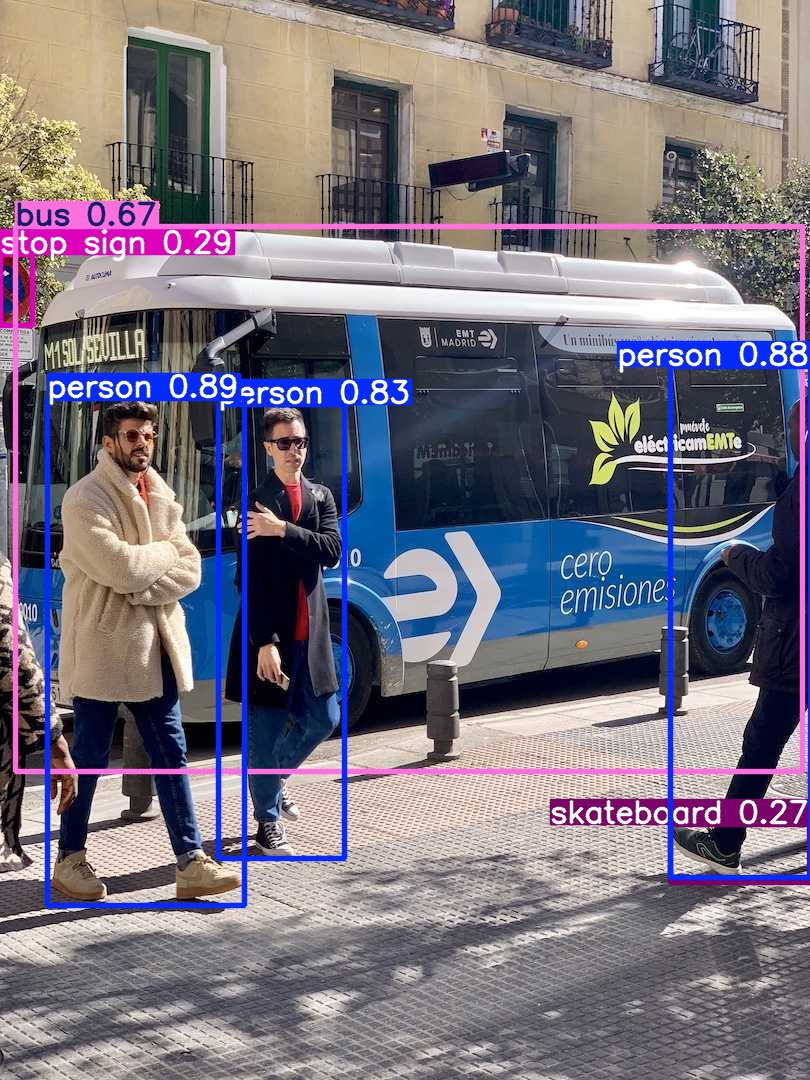

In [8]:
import urllib.request, os, glob
from IPython.display import Image, display

os.makedirs("test_images", exist_ok=True)
url = "https://raw.githubusercontent.com/ultralytics/ultralytics/main/ultralytics/assets/bus.jpg"
urllib.request.urlretrieve(url, "test_images/bus.jpg")

!yolo detect predict model={run_dir}/weights/best.pt source=test_images/ conf=0.25 save=True

pred_dirs = sorted(glob.glob("runs/detect/predict*"))
pred_dir = pred_dirs[-1]
pred_images = glob.glob(os.path.join(pred_dir, "*.jpg"))

for p in pred_images[:3]:
    display(Image(p, width=800))

Webcam

In [9]:
print("Webcam optionnelle, peut ne pas fonctionner sous Colab")

Webcam optionnelle, peut ne pas fonctionner sous Colab


 Mini-demo Gradio

In [10]:
!pip -q install gradio

import gradio as gr
from ultralytics import YOLO
import tempfile
import cv2, os

model = YOLO(f"{run_dir}/weights/best.pt")

def detect_objects(img):
    tmp = tempfile.NamedTemporaryFile(suffix=".jpg", delete=False)
    cv2.imwrite(tmp.name, cv2.cvtColor(img, cv2.COLOR_RGB2BGR))
    res = model.predict(source=tmp.name, conf=0.25, save=True,
project="runs/detect/gradio", name="pred", verbose=False)
    out_dir = res[0].save_dir
    outs = [p for p in os.listdir(out_dir) if p.lower().endswith((".jpg",".png",".jpeg"))]
    out_img = cv2.imread(os.path.join(out_dir, outs[0]))
    return cv2.cvtColor(out_img, cv2.COLOR_BGR2RGB)

demo = gr.Interface(fn=detect_objects, inputs=gr.Image(type="numpy"),
outputs=gr.Image(), title="YOLOv8 Demo")
demo.launch(share=True)

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://3cdf4f3dbe779a0bf6.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)




```
 Export du modèle



In [11]:
!yolo export model={run_dir}/weights/best.pt format=onnx opset=12
!yolo export model={run_dir}/weights/best.pt format=torchscript

Ultralytics 8.3.227 🚀 Python-3.12.12 torch-2.8.0+cu126 CPU (Intel Xeon CPU @ 2.00GHz)
💡 ProTip: Export to OpenVINO format for best performance on Intel hardware. Learn more at https://docs.ultralytics.com/integrations/openvino/
Model summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs

PyTorch: starting from 'runs/detect/train/weights/best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 84, 8400) (6.2 MB)
requirements: Ultralytics requirements ['onnx>=1.12.0,<=1.19.1', 'onnxslim>=0.1.71', 'onnxruntime'] not found, attempting AutoUpdate...
Using Python 3.12.12 environment at: /usr
Resolved 14 packages in 191ms
Prepared 6 packages in 1.46s
Installed 6 packages in 240ms
 + colorama==0.4.6
 + coloredlogs==15.0.1
 + humanfriendly==10.0
 + onnx==1.19.1
 + onnxruntime==1.24.0.dev20251031003
 + onnxslim==0.1.74

requirements: AutoUpdate success ✅ 2.5s
WARNING ⚠️ requirements: Restart runtime or rerun command for updates to take effect


ONNX: starting e

 Sauvegarde Google Drive

In [12]:
from google.colab import drive
drive.mount('/content/drive')

!mkdir -p "/content/drive/MyDrive/YOLO_TP"
!cp -r {run_dir} "/content/drive/MyDrive/YOLO_TP/"

print("Run transféré dans Google Drive")

Mounted at /content/drive
Run transféré dans Google Drive
